# Imports

In [1]:
import pandas              as pd
import numpy               as np
import math
import inflection
import datetime
import random
import warnings
import pickle
import requests

import seaborn             as sns
import matplotlib.pyplot   as plt

from tabulate              import tabulate
from scipy                 import stats
from IPython.core.display  import HTML
from IPython.display       import Image

from boruta                import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor

import xgboost as xgb

warnings.filterwarnings('ignore')

## Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1)/(n - 1))
    
    kcorr = k - (k - 1)**2/(n - 1)
    rcorr = r - (r - 1)**2/(n - 1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def machine_learning_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index= [0])


#time series
def cross_validation(x_training, kfold, model_name, model, verbose= False):
    mae_list= []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print('n\KFold Number: {}'.format(k))
            
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days= k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days= (k - 1) * 6 * 7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis= 1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis= 1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)
        
        #performance
        m_result = machine_learning_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' -/+ ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' -/+ ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' -/+ ' + np.round(np.std(rmse_list), 2).astype(str)}, index= [0])

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = False
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()


Populating the interactive namespace from numpy and matplotlib


## Loading Data

In [2]:
sales_dataframe = pd.read_csv('../data/train.csv', low_memory= False)
store_dataframe = pd.read_csv('../data/store.csv', low_memory= False)

#merge
raw_dataframe = pd.merge(sales_dataframe, store_dataframe, how= 'left', on= 'Store')

# Data Description

In [3]:
dataframe_2 = raw_dataframe.copy()

## Rename Columns

In [4]:
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list(map(snakecase, old_columns))

#rename
dataframe_2.columns = new_columns

In [6]:
dataframe_2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data Dimensions

In [7]:
print('Number of Rows: {}'.format(dataframe_2.shape[0]))
print('Number of Rows: {}'.format(dataframe_2.shape[1]))

Number of Rows: 1017209
Number of Rows: 18


## Data Types

In [8]:
dataframe_2.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
dataframe_2['date'] = pd.to_datetime(dataframe_2['date'])
dataframe_2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NaN

In [10]:
dataframe_2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Exitem 3 maneiras de tratar dados faltantes (NaN):
 - Excluir todas as linhas que possuem dados faltantes;
 - Usar algoritmo de ML e métodos estatísticos;
 - Entender o negócio.

## Fillout NAN

In [11]:
dataframe_2['competition_distance'].max()

75860.0

In [12]:
# competition_distance (distância em mêtros até a loja concorrente mais próxima)
dataframe_2['competition_distance'] = dataframe_2['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month (fornece o mês aproximados em que o concorrente mais próximo foi aberto)
dataframe_2['competition_open_since_month'] = dataframe_2.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis= 1)

# competition_open_since_year (fornece o ano aproximados em que o concorrente mais próximo foi aberto)
dataframe_2['competition_open_since_year'] = dataframe_2.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis= 1)

# promo2_since_week (descreve a semana em que a loja começou a participar da Promo2)
dataframe_2['promo2_since_week'] = dataframe_2.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis= 1)

# promo2_since_year (descreve o ano em que a loja começou a participar da Promo2)      
dataframe_2['promo2_since_year'] = dataframe_2.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis= 1)

#promo_interval (descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é reiniciada. )
month_map = {1: 'Jan', 2: 'Fev',3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

dataframe_2['promo_interval'].fillna(0, inplace= True)

dataframe_2['month_map'] = dataframe_2['date'].dt.month.map(month_map)

dataframe_2['is_promo'] = dataframe_2[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis= 1)

In [13]:
dataframe_2.sample(5).T

,726552,865348,802783,990901,629315
store,358,894,769,452,126
day_of_week,3,5,5,4,6
date,2013-09-18 00:00:00,2013-05-17 00:00:00,2013-07-12 00:00:00,2013-01-24 00:00:00,2013-12-14 00:00:00
sales,7657,10849,9395,5845,5892
customers,956,1312,2940,585,544
open,1,1,1,1,1
promo,0,1,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
...,...,...,...,...,...


In [14]:
dataframe_2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Data Types

In [15]:
#competition
dataframe_2['competition_open_since_month'] = dataframe_2['competition_open_since_month'].astype(int)
dataframe_2['competition_open_since_year'] = dataframe_2['competition_open_since_year'].astype(int)

#promo2
dataframe_2['promo2_since_week'] = dataframe_2['promo2_since_week'].astype(int)
dataframe_2['promo2_since_year'] = dataframe_2['promo2_since_year'].astype(int)

In [16]:
dataframe_2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## Descriptive Statistical

In [17]:
numeric_attributes = dataframe_2.select_dtypes(include=['int64', 'float64'])
categorical_attributes = dataframe_2.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributes

In [18]:
#Central Tendency - Mean, Median
mean = pd.DataFrame(numeric_attributes.apply(np.mean)).T
median = pd.DataFrame(numeric_attributes.apply(np.median)).T

#Dispersion - Std, Min, Max, range, skew, kurtosis
standard_deviation = pd.DataFrame(numeric_attributes.apply(np.std)).T
minimum = pd.DataFrame(numeric_attributes.apply(min)).T
maximum = pd.DataFrame(numeric_attributes.apply(max)).T
distance_between_minimum_and_maximum = pd.DataFrame(numeric_attributes.apply(lambda x: x.max() - x.min())).T
skewness = pd.DataFrame(numeric_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(numeric_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
vizualizer_descriptive_statistical = pd.concat([minimum, maximum, distance_between_minimum_and_maximum, mean, median, standard_deviation, skewness, kurtosis]).T.reset_index()
vizualizer_descriptive_statistical.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

vizualizer_descriptive_statistical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### Categorical Attributes

In [19]:
categorical_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

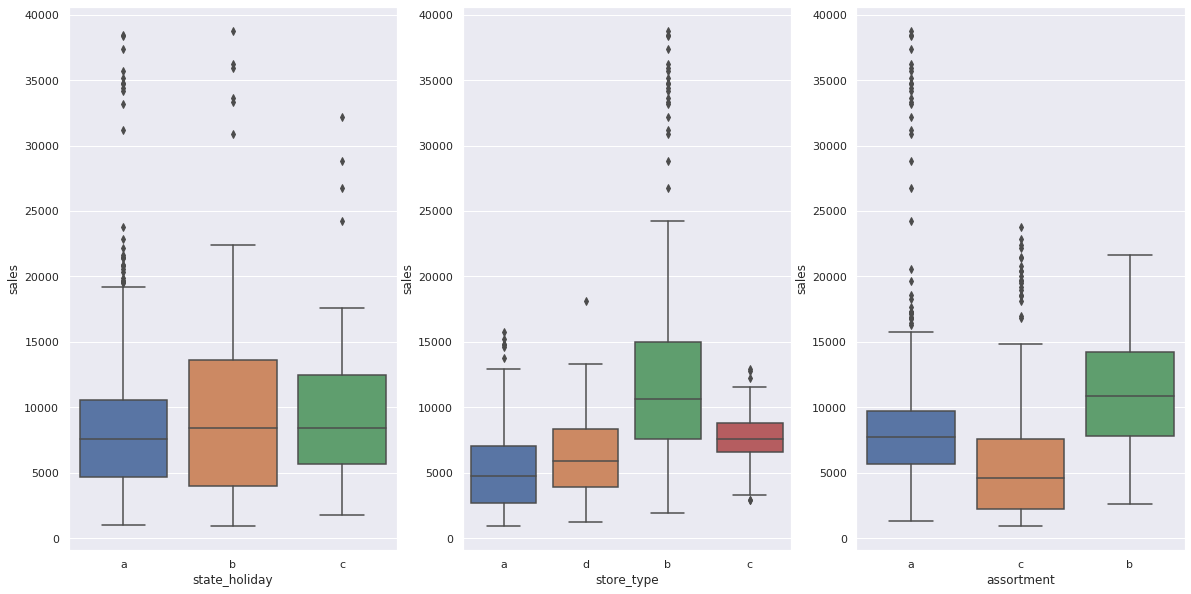

In [20]:
dataframe_aux = dataframe_2[(dataframe_2['state_holiday'] != '0') & (dataframe_2['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x= 'state_holiday' ,y= 'sales', data= dataframe_aux);

plt.subplot(1, 3, 2)
sns.boxplot(x= 'store_type' ,y= 'sales', data= dataframe_aux);

plt.subplot(1, 3, 3)
sns.boxplot(x= 'assortment' ,y= 'sales', data= dataframe_aux);

# Feature Engineering

In [21]:
dataframe_3 = dataframe_2.copy()

## MindMap Hypotesis

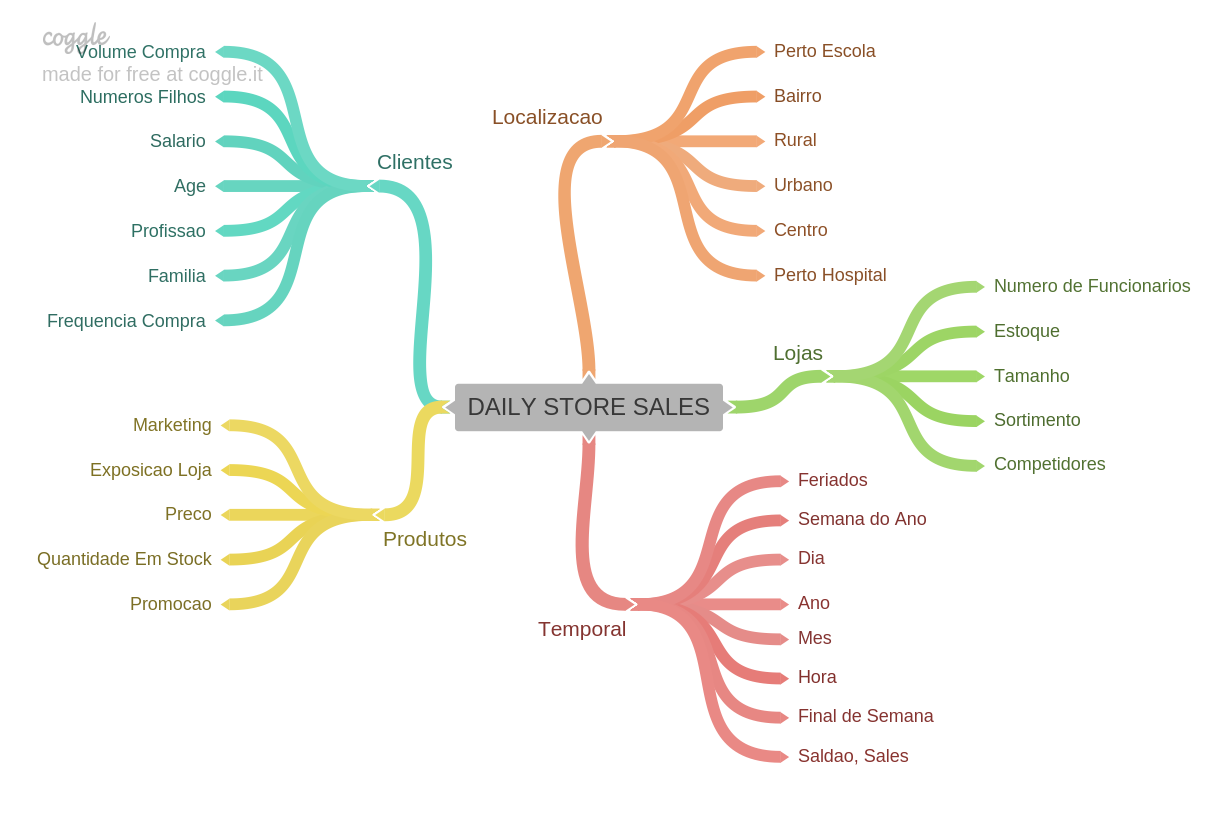

In [22]:
Image('../img/MindMapHypothesis.png')

## Creation of Hypotheses

### Hipóteses Loja

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores à mais tempo deveriam vender mais.


### Hipóteses Produto

**1.** Lojas que investem em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com menores preços deveriam vender mais.

**4.** Lojas com promoções mais agressivas (desconto maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais depois do dias 10 de cada mês.

**4.** Lojas deveriam vender mais no segundo semestre do ano.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender durante os feriados escolares.

### Lista Final de Hipótesis

Nesta etapa priorizaremos as hipótesis que poderão ser validadas, ou seja, se existe na base de dados, os dados necessários. Caso não tenha, será validade em no próximo ciclo depois de obter os dados necessários.

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano. 

**10.** Lojas deveriam vender mais depois do dias 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender durante os feriados escolares.

## Feature Engineering

In [23]:
#year
dataframe_3['year'] = dataframe_3['date'].dt.year

#month
dataframe_3['month'] = dataframe_3['date'].dt.month

#day
dataframe_3['day'] = dataframe_3['date'].dt.day

#week of year
dataframe_3['week_of_year'] = dataframe_3['date'].dt.weekofyear

#year week
dataframe_3['year_week'] = dataframe_3['date'].dt.strftime('%Y-%W')

#competition since 
dataframe_3['competition_since'] = dataframe_3.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1), axis= 1)
dataframe_3['competition_time_month'] = ((dataframe_3['date'] - dataframe_3['competition_since']) / 30).apply(lambda x: x.days).astype(int)

#promo since
dataframe_3['promo_since'] = dataframe_3['promo2_since_year'].astype(str) + '-' + dataframe_3['promo2_since_week'].astype(str)
dataframe_3['promo_since'] = dataframe_3['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days= 7))
dataframe_3['promo_time_week'] = ((dataframe_3['date'] - dataframe_3['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
dataframe_3['assortment'] = dataframe_3['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday 
dataframe_3['state_holiday'] = dataframe_3['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [24]:
dataframe_3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
...,...,...,...,...,...


## Filtering Variables

In [25]:
dataframe_3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### Line Filtering

In [26]:
dataframe_3 = dataframe_3[(dataframe_3['open'] != 0) & (dataframe_3['sales'] > 0)]

### Column Selection

In [27]:
excluded_columns = ['customers', 'open', 'promo_interval', 'month_map']
dataframe_3 = dataframe_3.drop(excluded_columns, axis= 1)

# Exploratory Data Analysis

In [28]:
dataframe_4 = dataframe_3.copy()
dataframe_4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## Univariate Analysis

### Responde Variable

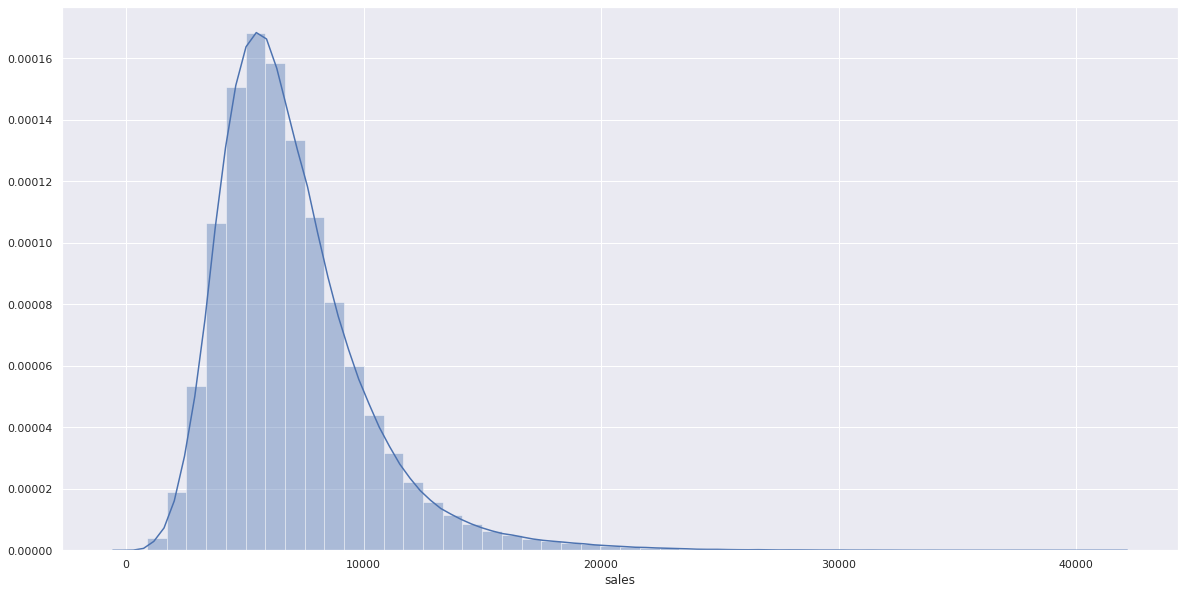

In [29]:
sns.distplot(dataframe_4['sales']);

### Numeric Variables

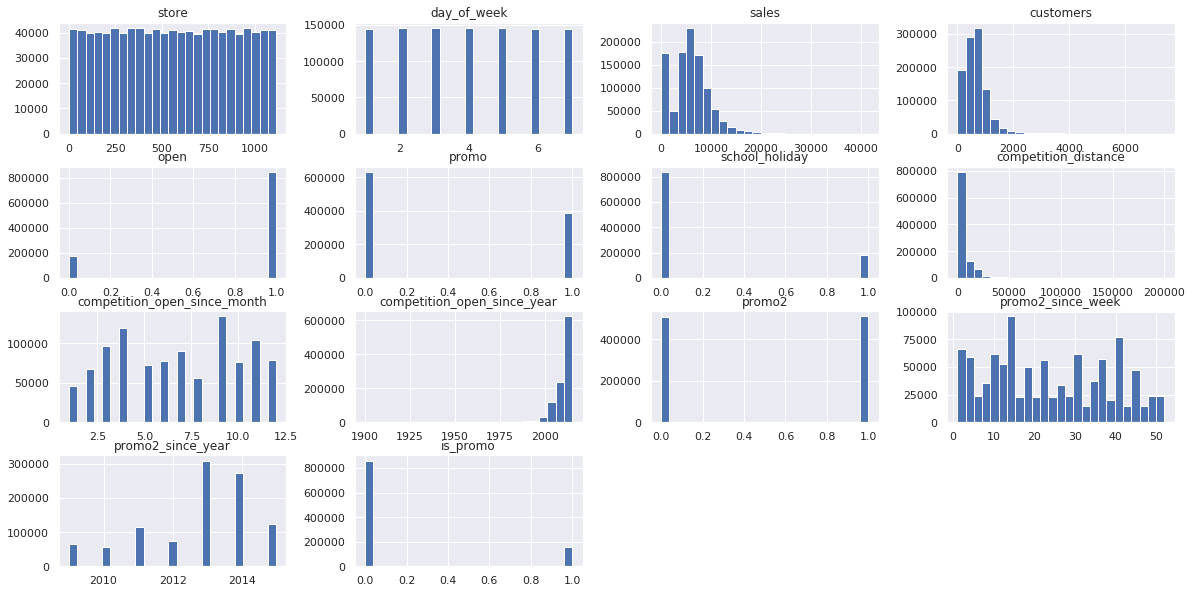

In [30]:
numeric_attributes.hist(bins= 25);

### Categoric Variables

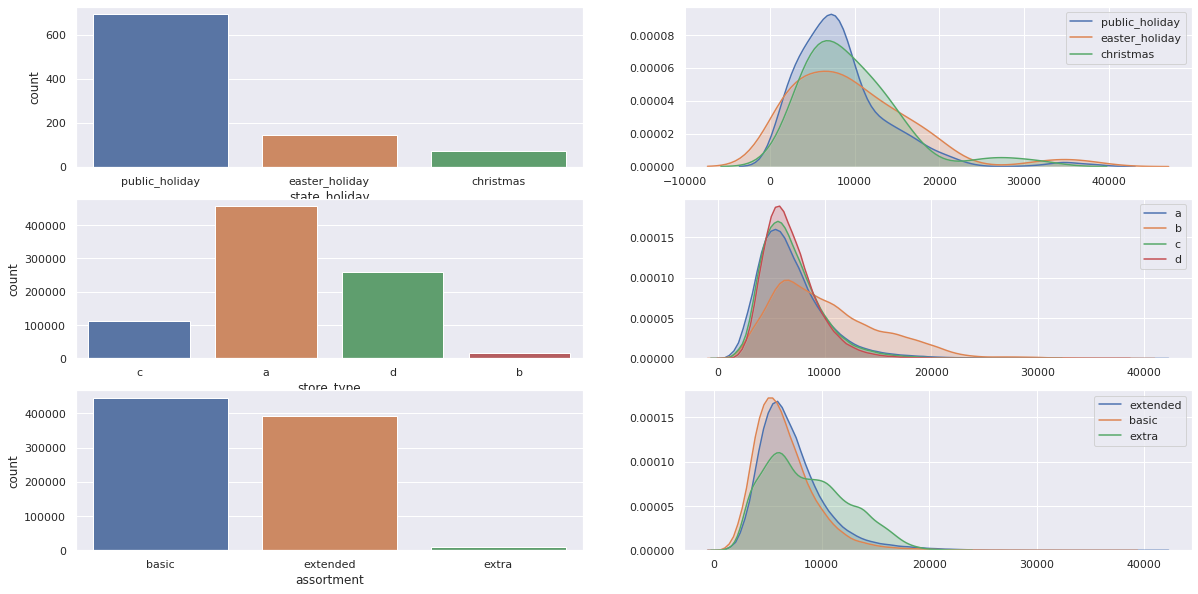

In [31]:
# state_holiday
plt.subplot( 3, 2, 1 )
dataframe_aux = dataframe_4[dataframe_4['state_holiday'] != 'regular_day']
sns.countplot( dataframe_aux['state_holiday'] );

plt.subplot( 3, 2, 2 )
sns.kdeplot( dataframe_4[dataframe_4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True );
sns.kdeplot( dataframe_4[dataframe_4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True );
sns.kdeplot( dataframe_4[dataframe_4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True );

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( dataframe_4['store_type'] );

plt.subplot( 3, 2, 4 )
sns.kdeplot( dataframe_4[dataframe_4['store_type'] == 'a']['sales'], label='a', shade=True );
sns.kdeplot( dataframe_4[dataframe_4['store_type'] == 'b']['sales'], label='b', shade=True );
sns.kdeplot( dataframe_4[dataframe_4['store_type'] == 'c']['sales'], label='c', shade=True );
sns.kdeplot( dataframe_4[dataframe_4['store_type'] == 'd']['sales'], label='d', shade=True );

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( dataframe_4['assortment'] );

plt.subplot( 3, 2, 6 )
sns.kdeplot( dataframe_4[dataframe_4['assortment'] == 'extended']['sales'], label='extended', shade=True );
sns.kdeplot( dataframe_4[dataframe_4['assortment'] == 'basic']['sales'], label='basic', shade=True );
sns.kdeplot( dataframe_4[dataframe_4['assortment'] == 'extra']['sales'], label='extra', shade=True );

## Bivariate Analysis

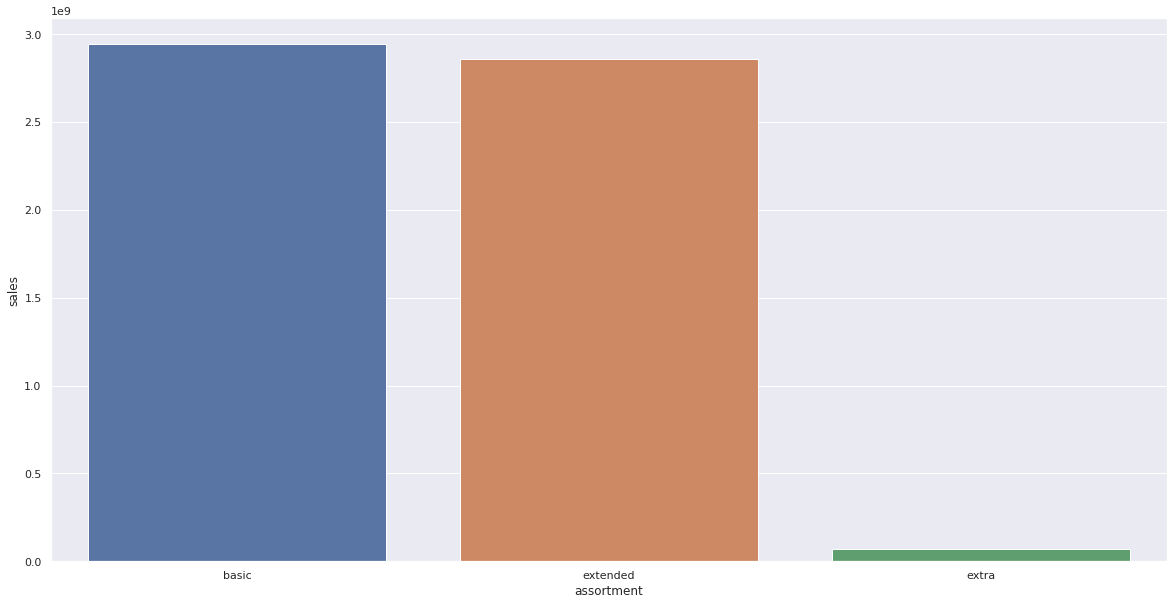

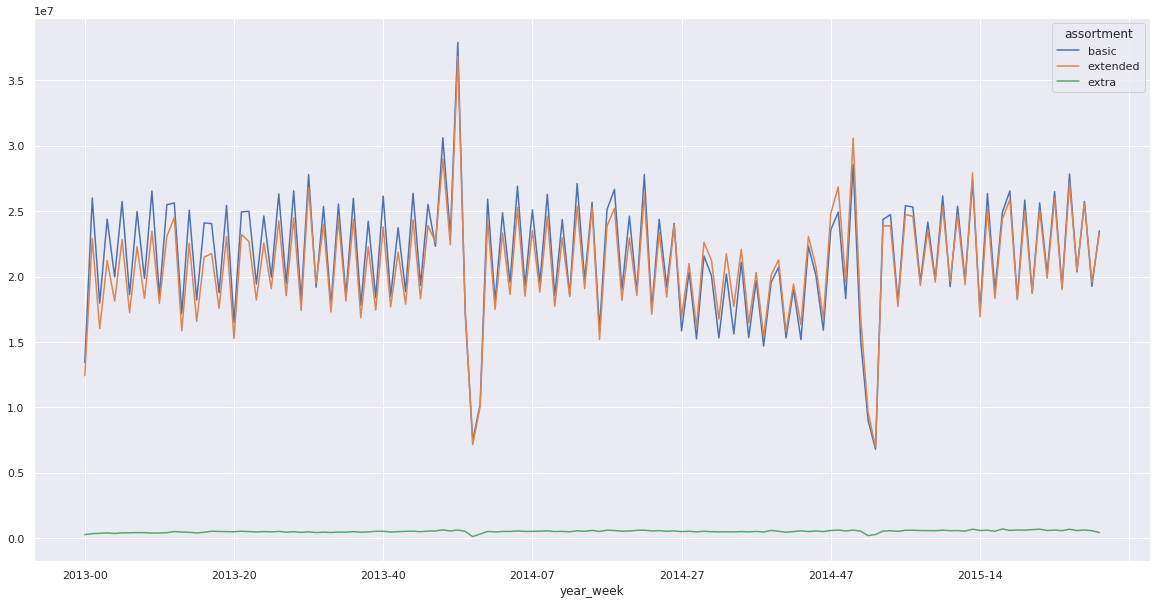

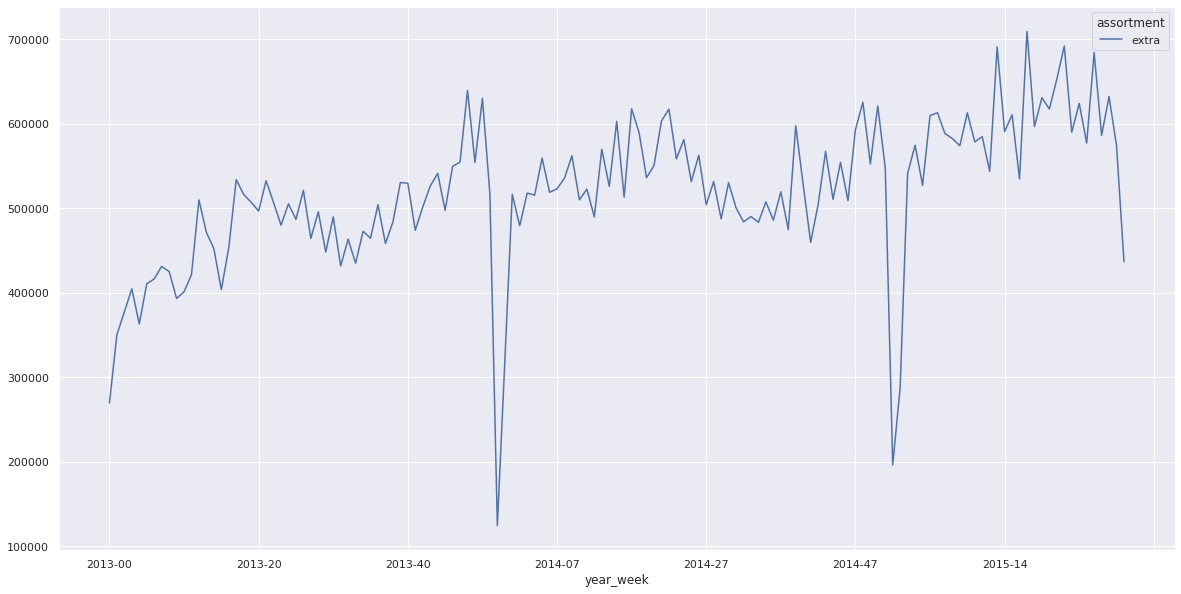

In [32]:
#H1. Lojas com maior sortimento deveriam vender mais. 
dataframe_aux = dataframe_4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data= dataframe_aux);

dataframe_aux2 = dataframe_4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
dataframe_aux2.pivot(index='year_week', columns= 'assortment', values='sales').plot();

dataframe_aux3 = dataframe_aux2[dataframe_aux2['assortment'] == 'extra']
dataframe_aux3.pivot(index='year_week', columns= 'assortment', values='sales').plot();

#R: Falsa. Lojas com maior sortimentos vendem menos.

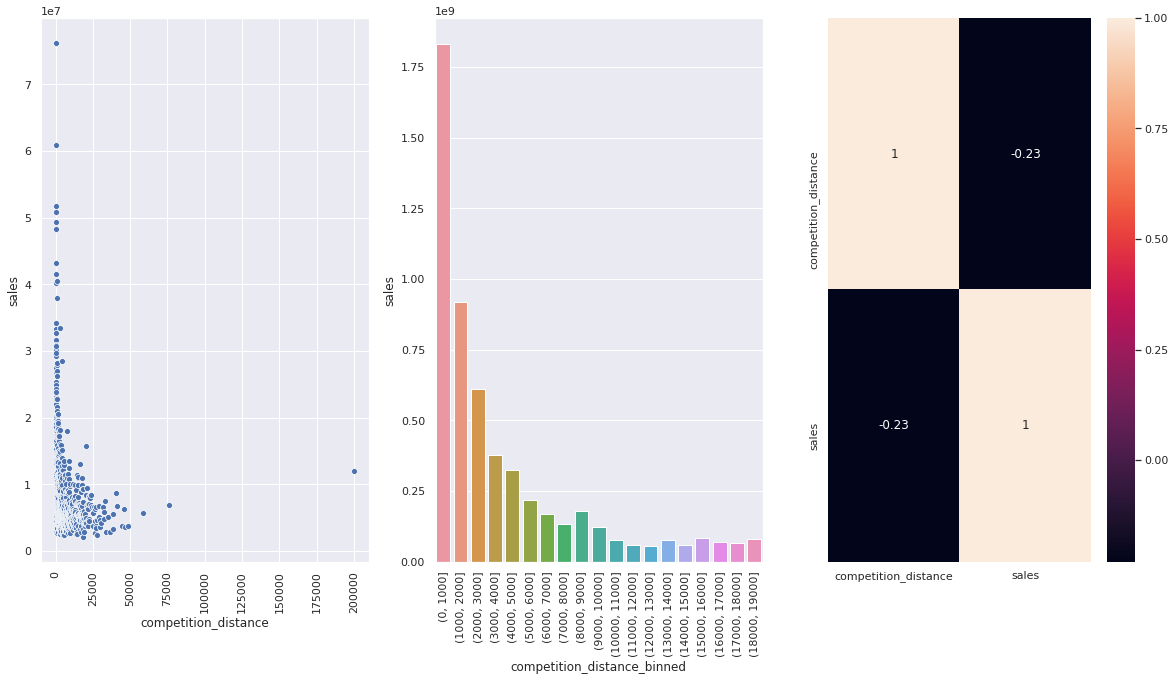

In [33]:
#H2. Lojas com competidores mais próximos deveriam vender menos.
dataframe_aux = dataframe_4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y= 'sales', data= dataframe_aux);
plt.xticks(rotation= 90)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
dataframe_aux['competition_distance_binned'] = pd.cut(dataframe_aux['competition_distance'], bins= bins)
dataframe_aux2 = dataframe_aux[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x= 'competition_distance_binned', y= 'sales', data= dataframe_aux2);
plt.xticks(rotation= 90)

plt.subplot(1, 3, 3)
sns.heatmap(dataframe_aux.corr(method= 'pearson'), annot= True);

#R: Falsa. Loja com competidores mais próximos vendem mais.

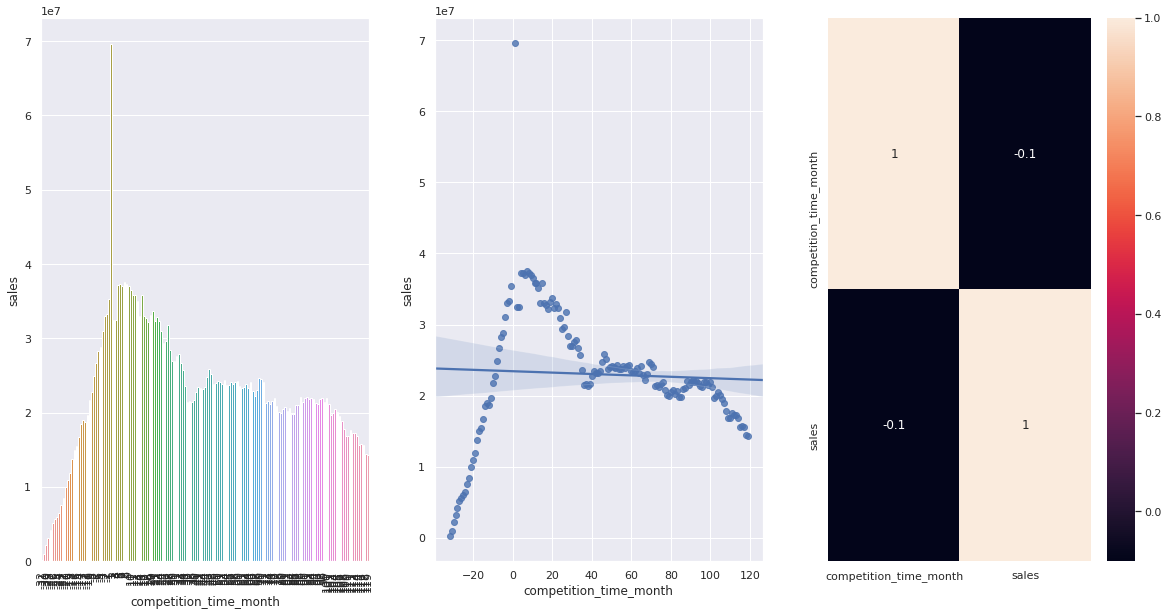

In [34]:
#H3: Lojas com competidores à mais tempo deveriam vender mais.

plt.subplot(1, 3, 1)
dataframe_aux = dataframe_4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
dataframe_aux2 = dataframe_aux[(dataframe_aux['competition_time_month'] < 120) & (dataframe_aux['competition_time_month'] != 0)]
sns.barplot(x= 'competition_time_month', y= 'sales', data= dataframe_aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x= 'competition_time_month', y= 'sales', data= dataframe_aux2);

plt.subplot(1, 3, 3)
sns.heatmap(dataframe_aux.corr(method= 'pearson'), annot= True);

#R: Falsa. Lojas com competidores à mais tempo vendem menos.

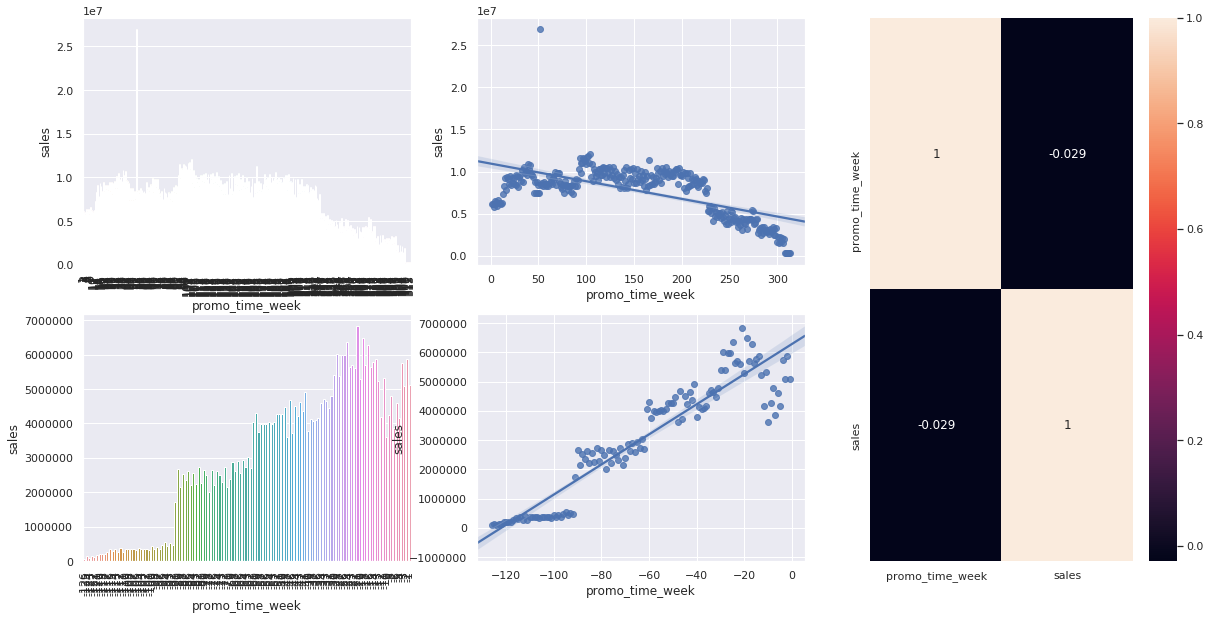

In [35]:
#4. Lojas com promoções ativas por mais tempo deveriam vender mais.
dataframe_aux = dataframe_4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, 0])
dataframe_aux2 = dataframe_aux[dataframe_aux['promo_time_week']> 0] #promo extendido
sns.barplot(x= 'promo_time_week', y= 'sales', data= dataframe_aux2);
plt.xticks(rotation= 90);

plt.subplot(grid[0, 1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= dataframe_aux2);

plt.subplot(grid[1, 0])
dataframe_aux3 = dataframe_aux[dataframe_aux['promo_time_week']< 0] #promo regular
sns.barplot(x= 'promo_time_week', y= 'sales', data= dataframe_aux3);
plt.xticks(rotation= 90);

plt.subplot(grid[1, 1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= dataframe_aux3);

plt.subplot(grid[:, 2])
sns.heatmap(dataframe_aux.corr(method= 'pearson'), annot= True);

#R: Falsa. Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

In [36]:
#H5: Lojas com mais dias de promoção deveriam vender mais. (mais dias de produção)
#R: próximo ciclo

In [37]:
#H6: Lojas com mais promoções consecutivas deveriam vender mais.
dataframe_4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(['sales'])

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


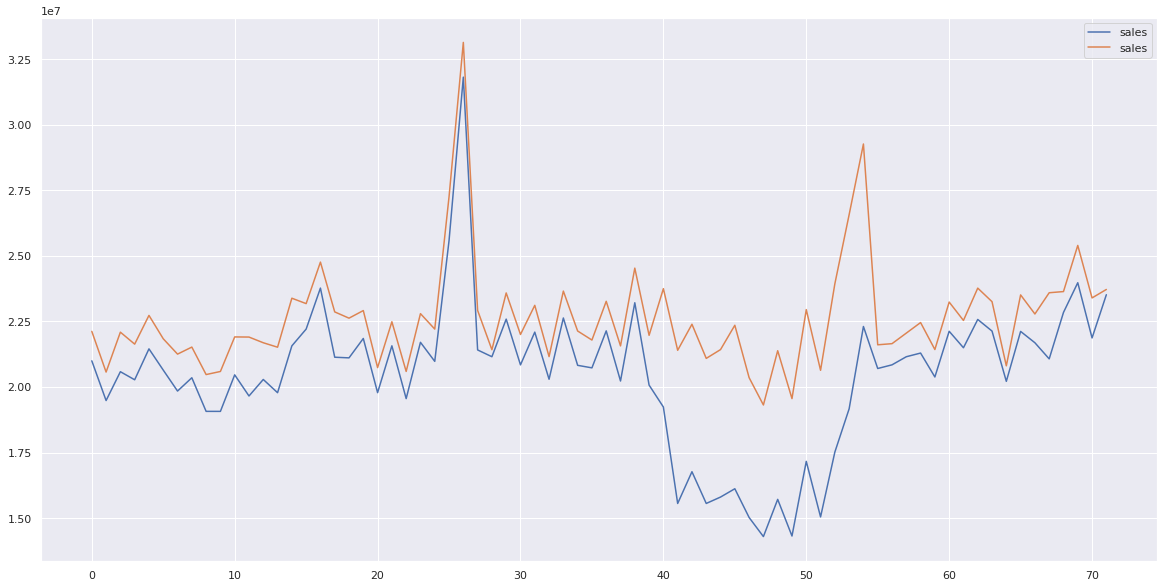

In [38]:
dataframe_aux = dataframe_4[(dataframe_4['promo'] == 1) & (dataframe_4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = dataframe_aux.plot();

dataframe_aux2 = dataframe_4[(dataframe_4['promo'] == 1) & (dataframe_4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
dataframe_aux2.plot(ax= ax);

#R: Falsa. Lojas com mais promoções consecutivas vendem menos.

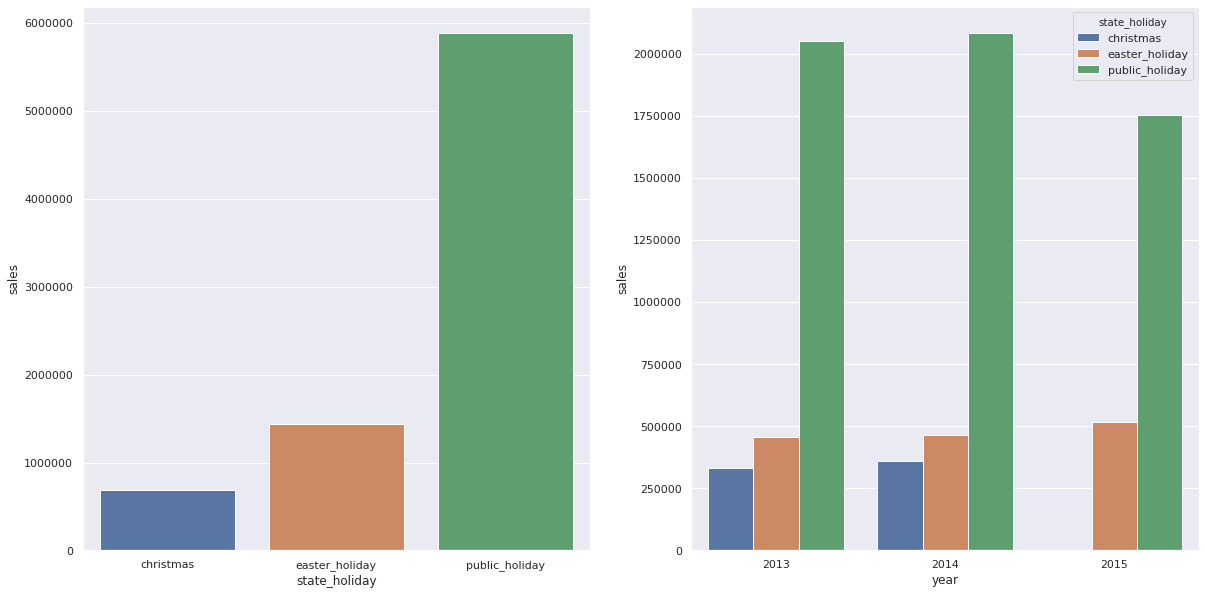

In [39]:
#7. Lojas abertas durante o feriado de Natal deveriam vender mais.
dataframe_aux = dataframe_4[dataframe_4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
dataframe_aux1 = dataframe_aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x= 'state_holiday', y= 'sales', data= dataframe_aux1);

plt.subplot(1, 2, 2)
dataframe_aux2 = dataframe_aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x= 'year', y= 'sales', hue= 'state_holiday', data= dataframe_aux2);

#R: Falsa. Lojas abertas durante o feriado do Natal vendem menos.

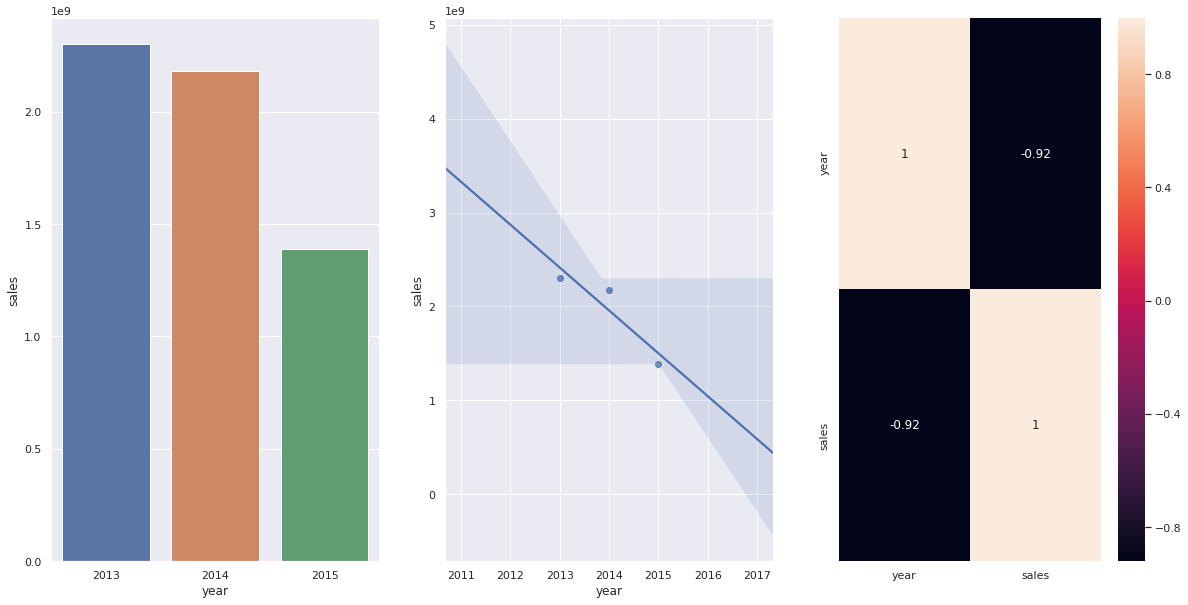

In [40]:
#H8: Lojas deveriam vender mais ao longo dos anos.
dataframe_aux = dataframe_4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x= 'year', y= 'sales', data= dataframe_aux);

plt.subplot(1, 3, 2)
sns.regplot(x= 'year', y= 'sales', data= dataframe_aux);

plt.subplot(1, 3, 3)
sns.heatmap(dataframe_aux.corr(method= 'pearson'), annot= True);

#R: Falsa. Lojas vendem menos ao longo dos anos. (porém o ano de 2015 não terminou, o que influência no resultado.)

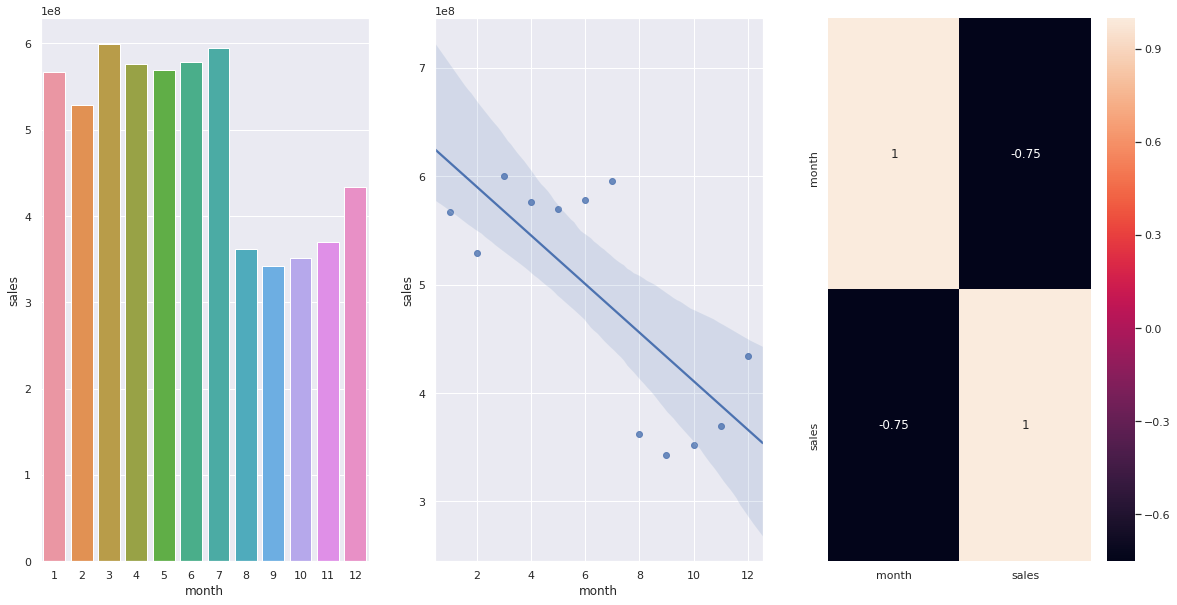

In [41]:
#H9: Lojas deveriam vender mais no segundo semestre do ano.
dataframe_aux = dataframe_4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x= 'month', y= 'sales', data= dataframe_aux);

plt.subplot(1, 3, 2)
sns.regplot(x= 'month', y= 'sales', data= dataframe_aux);

plt.subplot(1, 3, 3)
sns.heatmap(dataframe_aux.corr(method= 'pearson'), annot= True);

#R: Falsa. Lojas vendem menos no segundo semestre do ano.

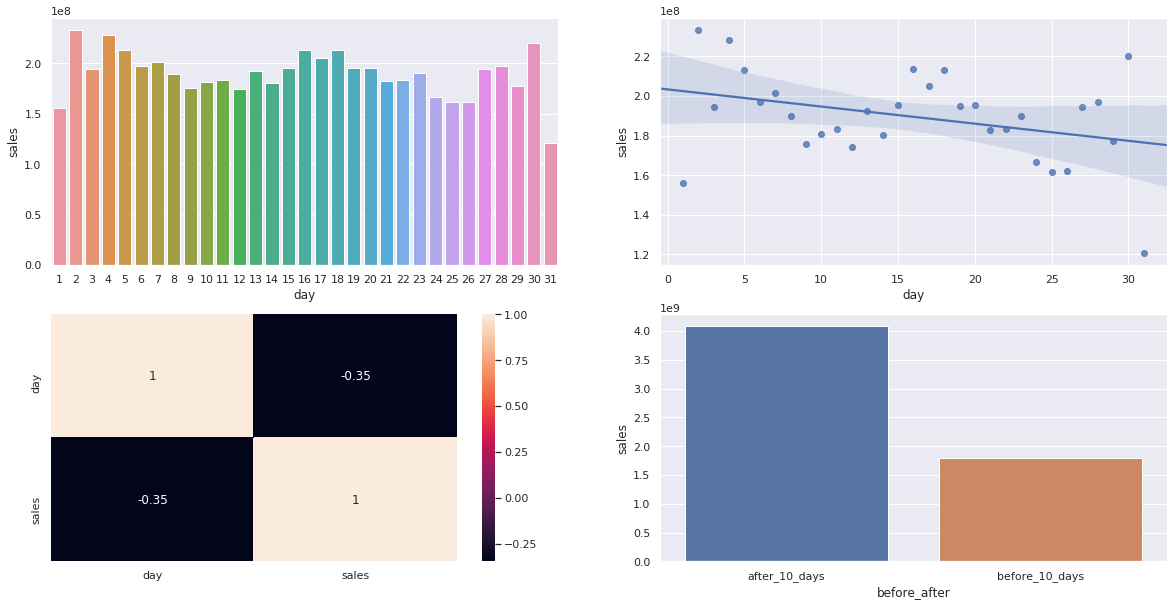

In [42]:
#H10: Lojas deveriam vender mais depois do dias 10 de cada mês.
dataframe_aux = dataframe_4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x= 'day', y= 'sales', data= dataframe_aux)

plt.subplot(2, 2, 2)
sns.regplot(x= 'day', y= 'sales', data= dataframe_aux)

plt.subplot(2, 2, 3)
sns.heatmap(dataframe_aux.corr(method= 'pearson'), annot= True)

dataframe_aux['before_after'] = dataframe_aux['day'].apply(lambda x: 'before_10_days' if x < 10 else 'after_10_days')
dataframe_aux2 = dataframe_aux[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x= 'before_after', y= 'sales', data= dataframe_aux2);

#R: Verdadeira. Lojas vendem mais depois do dia 10 de cada mês.

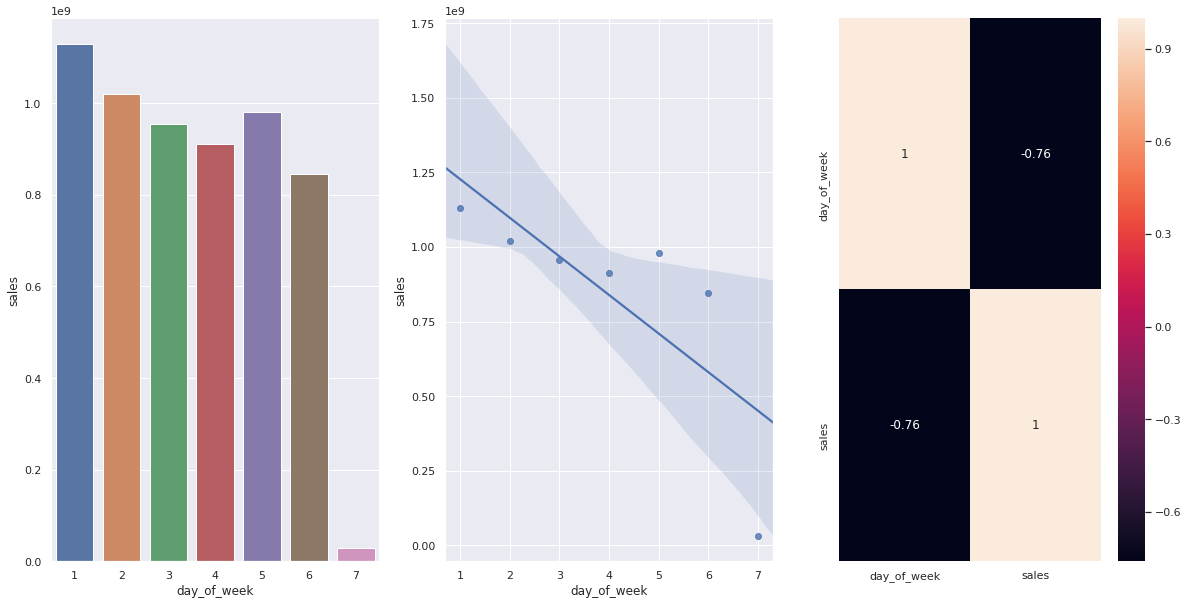

In [43]:
#H11: Lojas deveriam vender menos aos finais de semana.
dataframe_aux = dataframe_4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x= 'day_of_week', y= 'sales', data= dataframe_aux);

plt.subplot(1, 3, 2)
sns.regplot(x= 'day_of_week', y= 'sales', data= dataframe_aux);

plt.subplot(1, 3, 3)
sns.heatmap(dataframe_aux.corr(method= 'pearson'), annot= True);

#R: Verdadeira. Lojas vendem menos nos finais de semana.

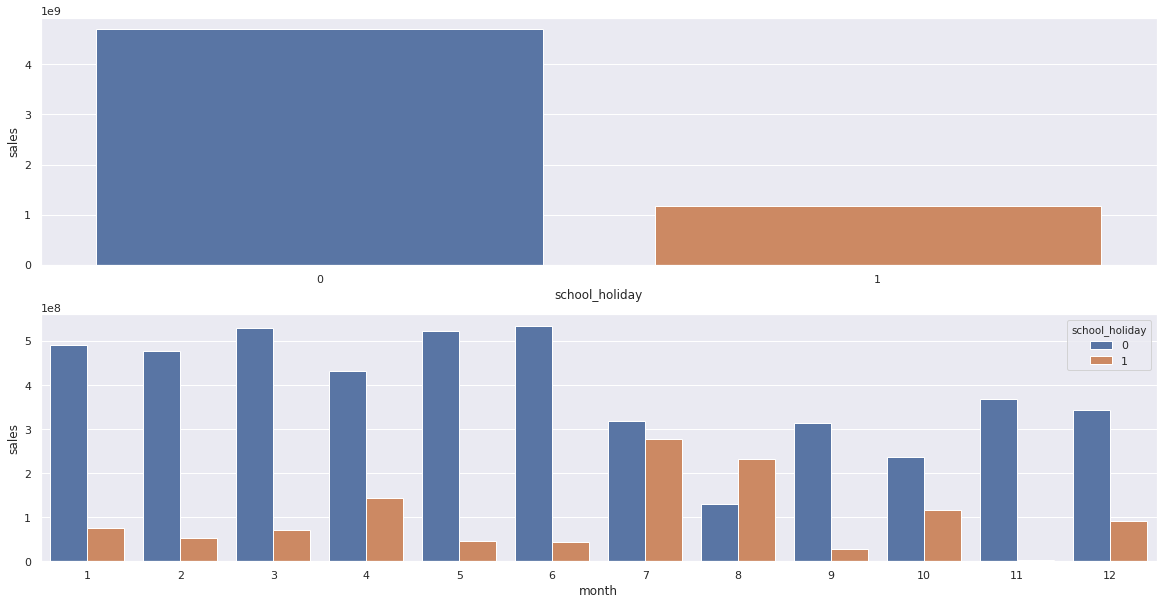

In [44]:
#H12: Lojas deveriam vender menos durante os feriados escolares.
dataframe_aux = dataframe_4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x= 'school_holiday', y= 'sales', data= dataframe_aux);

dataframe_aux2 = dataframe_4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2, 1, 2)
sns.barplot(x= 'month', y= 'sales', hue= 'school_holiday', data= dataframe_aux2);

#R: Verdadeira. Lojas vendem menos durante os feriados escolares, exceto nos meses de Julho e Agosto.

### Resumo das Hipóteses

In [45]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-----', '-----'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']]
print(tabulate(tab, headers= 'firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -----        -----
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## Análise Multivariada

### Numerical Attributes

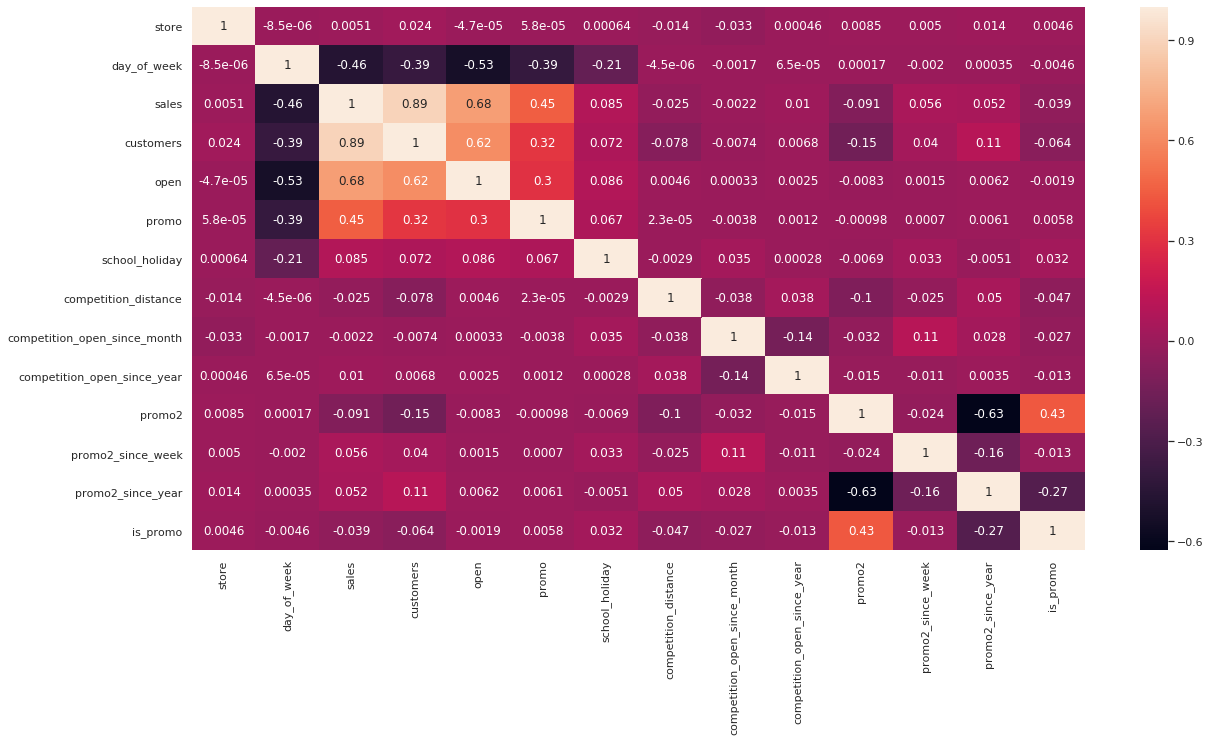

In [46]:
correlation = numeric_attributes.corr(method= 'pearson')
sns.heatmap(correlation, annot= True);

### Categorical Attributes

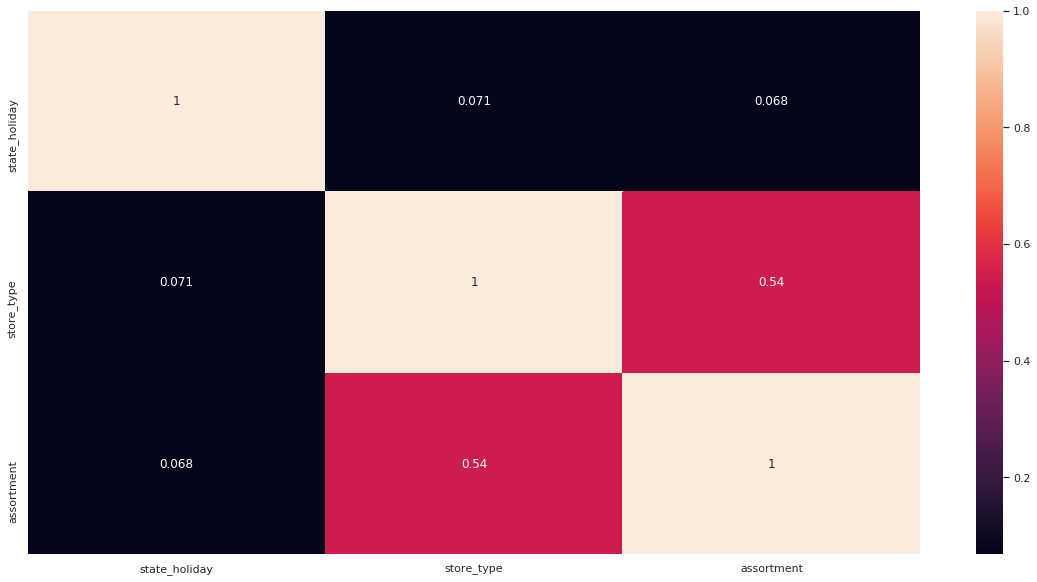

In [47]:
#only categorical data
categorical_dataframe = dataframe_4.select_dtypes(include= 'object')

#calculate Cramer's V
cramer_v1 = cramer_v(categorical_dataframe['state_holiday'], categorical_dataframe['state_holiday'])
cramer_v2 = cramer_v(categorical_dataframe['state_holiday'], categorical_dataframe['store_type'])
cramer_v3 = cramer_v(categorical_dataframe['state_holiday'], categorical_dataframe['assortment'])

cramer_v4 = cramer_v(categorical_dataframe['store_type'], categorical_dataframe['state_holiday'])
cramer_v5 = cramer_v(categorical_dataframe['store_type'], categorical_dataframe['store_type'])
cramer_v6 = cramer_v(categorical_dataframe['store_type'], categorical_dataframe['assortment'])

cramer_v7 = cramer_v(categorical_dataframe['assortment'], categorical_dataframe['state_holiday'])
cramer_v8 = cramer_v(categorical_dataframe['assortment'], categorical_dataframe['store_type'])
cramer_v9 = cramer_v(categorical_dataframe['assortment'], categorical_dataframe['assortment'])

#final dataset
cramer_v_dataset = pd.DataFrame({'state_holiday': [cramer_v1, cramer_v2, cramer_v3],
              'store_type': [cramer_v4, cramer_v5, cramer_v6], 
              'assortment': [cramer_v7, cramer_v8, cramer_v9]})

cramer_v_dataset = cramer_v_dataset.set_index(cramer_v_dataset.columns)

sns.heatmap(cramer_v_dataset, annot= True);

# Data Preparation

In [48]:
dataframe_5 = dataframe_4.copy()

## Normalization

In [49]:
# Ir na parte de análise exploratória e identificar as variáveis que possuem uma distribuição normal.
# Nenhuma variável possui uma distribuição normal, logo será descartada o processo de normalização.

## Rescaling

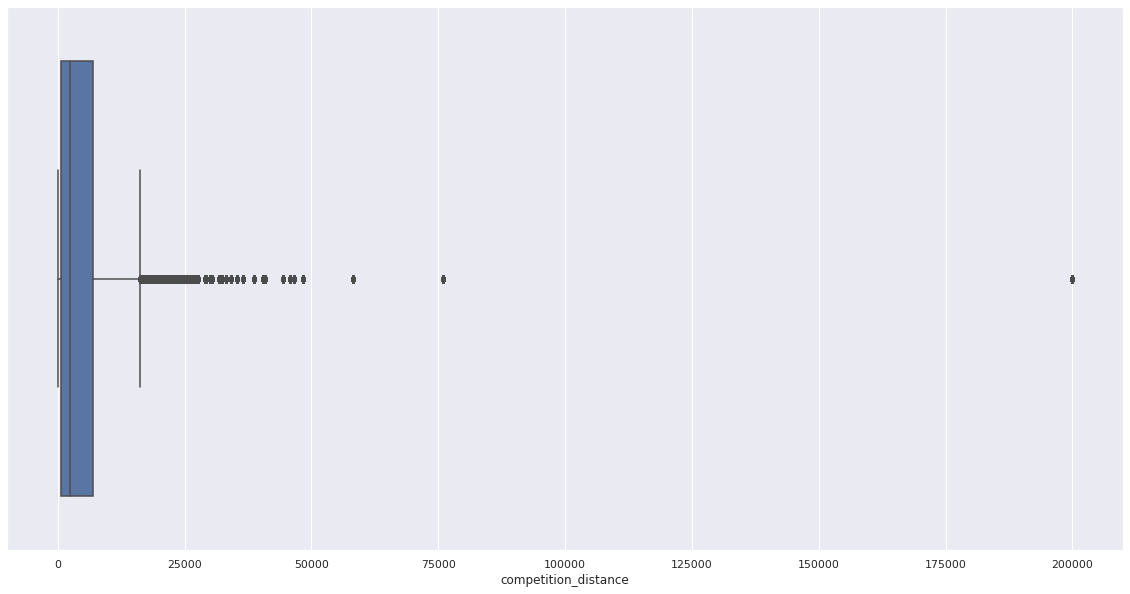

In [50]:
# competition distance
sns.boxplot(dataframe_5['competition_distance']);

In [51]:
robust_scaler = RobustScaler()
min_max_scaler = MinMaxScaler()

In [120]:
dataframe_5['competition_distance'] = robust_scaler.fit_transform(dataframe_5[['competition_distance']].values)

outfile = open('../parameters/competition_distance_scaler.pkl', 'wb')
pickle.dump(robust_scaler, outfile)


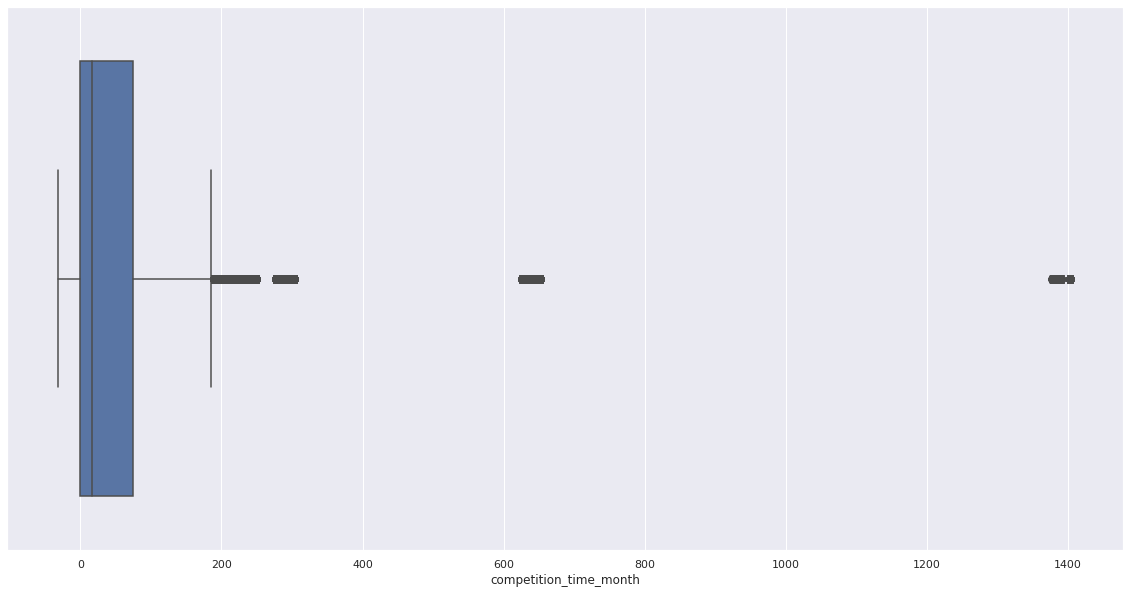

In [53]:
# competition time month
sns.boxplot(dataframe_5['competition_time_month']);

In [121]:
dataframe_5['competition_time_month'] = robust_scaler.fit_transform(dataframe_5[['competition_time_month']].values)

outfile = open('../parameters/competition_time_month_scaler.pkl', 'wb')
pickle.dump(robust_scaler, outfile)

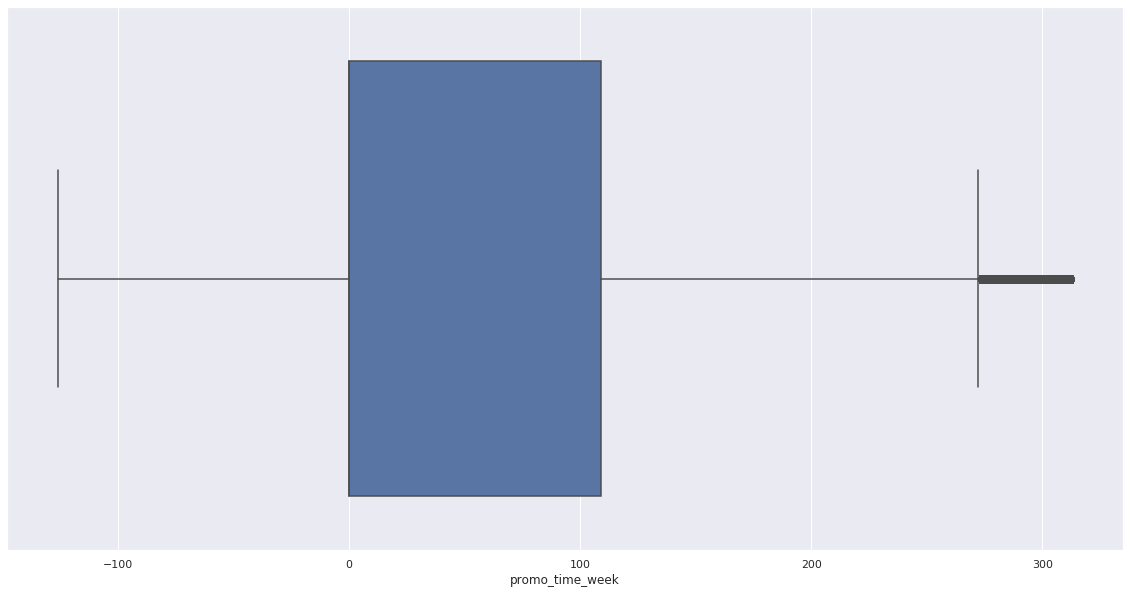

In [55]:
# promo time week
sns.boxplot(dataframe_5['promo_time_week']);

In [122]:
dataframe_5['promo_time_week'] = min_max_scaler.fit_transform(dataframe_5[['promo_time_week']].values)

outfile = open('../parameters/promo_time_week_scaler.pkl', 'wb')
pickle.dump(min_max_scaler, outfile)

In [123]:
#year
dataframe_5['year'] = min_max_scaler.fit_transform(dataframe_5[['year']].values)

outfile = open('../parameters/year_scaler.pkl', 'wb')
pickle.dump(min_max_scaler, outfile)

## Transformation

### Encoding

In [58]:
dataframe_5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [59]:
# state holiday >>> one hot encoding
dataframe_5 = pd.get_dummies(dataframe_5, prefix= ['state_holiday'], columns= ['state_holiday'])
dataframe_5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [149]:
# store type >>> label encoding
label_encoder = LabelEncoder()
dataframe_5['store_type'] = label_encoder.fit_transform(dataframe_5['store_type'].values)

outfile = open('../parameters/store_type_scaler.pkl', 'wb')
pickle.dump(label_encoder, outfile)

In [148]:
dataframe_5['store_type']

0          2
1          0
2          0
3          2
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
          ..
1016447    1
1016517    1
1016588    1
1016606    1
1016624    0
1016656    1
1016770    1
1016776    1
1016827    1
1016863    1
1017042    1
1017190    1
Name: store_type, Length: 844338, dtype: int64

In [61]:
dataframe_5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [62]:
# assortment >>> ordinal encoding
assortment_dictionary = {'basic': 1,
                         'extra': 2,
                         'extended': 3}
dataframe_5['assortment'] = dataframe_5['assortment'].map(assortment_dictionary)

In [63]:
dataframe_5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### Response Variable Transformation

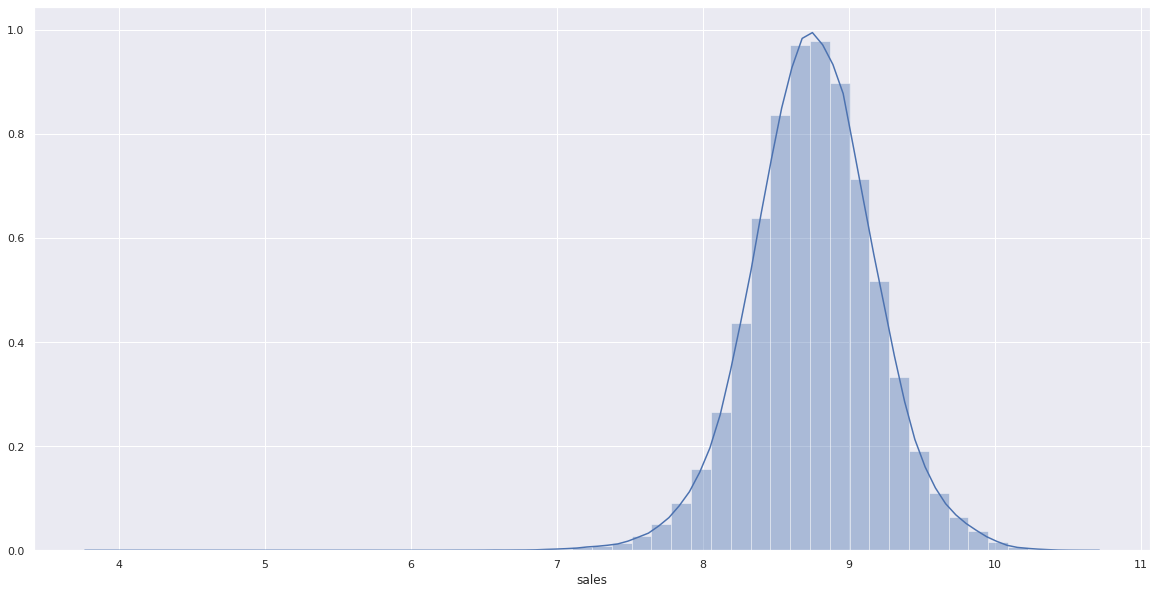

In [64]:
#Tranformação Logaritmica
dataframe_5['sales'] = np.log1p(dataframe_5['sales'])
sns.distplot(dataframe_5['sales']);

### Nature Transformation

In [65]:
# day of week
dataframe_5['day_of_week_sin'] = dataframe_5['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/7)))
dataframe_5['day_of_week_cos'] = dataframe_5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/7)))

# month
dataframe_5['month_sin'] = dataframe_5['month'].apply(lambda x: np.sin( x * (2 * np.pi/12)))
dataframe_5['month_cos'] = dataframe_5['month'].apply(lambda x: np.cos( x * (2 * np.pi/12)))

# day
dataframe_5['day_sin'] = dataframe_5['day'].apply(lambda x: np.sin( x * (2 * np.pi/30)))
dataframe_5['day_cos'] = dataframe_5['day'].apply(lambda x: np.cos( x * (2 * np.pi/30)))

# week of year
dataframe_5['week_of_year_sin'] = dataframe_5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/52)))
dataframe_5['week_of_year_cos'] = dataframe_5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/52)))

In [66]:
dataframe_5.sample()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
95508,734,4,2015-05-07,8.810012,1,0,0,1,-0.340323,5,2015,1,36,2013,0,1.0,5,7,19,2015-18,2015-05-01,-0.216216,2013-09-02,0.485194,0,0,0,1,-0.433884,-0.900969,0.5,-0.866025,0.994522,0.104528,0.748511,-0.663123


# Feature/Variable Selection

In [67]:
dataframe_6 = dataframe_5.copy()

## Split dataframe into training and test dataset 

In [68]:
dataframe_6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [69]:
dataframe_6.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'state_holiday_christmas', 'state_holiday_easter_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos'],
      dtype='object')

In [70]:
excluded_columns = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
dataframe_6 = dataframe_6.drop(excluded_columns, axis= 1)

In [71]:
print(dataframe_6[['store', 'date']].groupby('store').max().reset_index()['date'][0])
print(dataframe_6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days= 6 * 7))

# De 19/06/2015 a 31/05/2015 serão os dados para Treino

2015-07-31 00:00:00
2015-06-19 00:00:00


In [72]:
# training dataset
x_train = dataframe_6[dataframe_6['date'] < '2015-06-19']
y_train = x_train['sales']

#test dataset
x_test = dataframe_6[dataframe_6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Training Min Date: {}' .format(x_train['date'].min()))
print('Training Max Date: {}' .format(x_train['date'].max()))
print('')
print('Test Min Date: {}' .format(x_test['date'].min()))
print('Test Max Date: {}' .format(x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Boruta as Feature Selector

<b>O Funcionamento do Algoritmo Boruta</b>

 O algoritmo seleciona variáveis aleatórias no conjunto de dados e cria o mesmo número de variáveis selecionadas de variáveis chamadas de shadows (cópia da variável original com os registros randomizados, tem a funcão de anular a correlação entre variáveis). A partir dessa nova criação de variáveis, há um novo conjunto de dados que serão treinados por um modelo (ex.: Random Forest). Após o treinamento do modelo, encontra-se a importância de cada variável/feature e busca comparar a variável shadow mais importante do conjunto com a importância das variáveis originais. Se a variável original tiver um número de importância maior que o número da variável shadow mais importante, em uma outra tabela, coloca o valor 1 para essa variável. Se for menor, coloca 0 para a variável. Esse processo é repetido inúmeras vezes, sempre randomizando os valores das variáveis shadows e aumentando a contagem de sucesso (tabela criada possuindo o valor 1). A partir dessa tabela é possivel usar uma distribuição de binomial para calcular o p-value de cada variável e determinar sua importância.
 Uma vez calculado o p-value das variáveis, constrói a distribuição binomial e "seta" um p-valor threshold, assumindo que, se a variável possuir um p-value maior que o threshold é confirmado que a variável não é importante, logo a variável é rejeitada, se for menor a variável é confirmada e importante para o aprendizado.

In [73]:
## trainning and test dataset for Boruta
#x_train_boruta= x_train.drop(['date', 'sales'], axis= 1).values
#y_train_boruta = y_train.values.ravel()

In [74]:
### >>> Migrar para Colabs
# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose= 2, random_state= 42).fit(x_train_boruta, y_train_boruta)

### Best Features from Boruta

In [76]:
#columns_selected = boruta.support_.tolist()
#
#x_train_features_selected = x_train.drop(['date', 'sales', axis= 1])
#cols_selected_boruta = x_train_features_selected.iloc[:, columns_selected].columns.to_list()
#
#columns_not_selected_boruta = list(np.setdiff1d(x_train_features_selected.columns, columns_selected_boruta))

<u>As features/variáveis mais relvantes segundo o modelo são</u>: store, promo, store_type, assortment, competition_distance, competition_open_since_month, competition_open_since_year, promo2, promo2_since_week, promo2_since_year, competition_time_month, promo_time_week, day_of_week_sin, day_of_week_cos, month_cos, day_sin, day_cos, week_of_year_cos.

<u>As features rejeitadas foram</u>: is_promo, month_sin, school_holiday, state_holiday_christmas, state_holiday_easter_holiday, state_holiday_public_holiday, state_soliday_day_regular, week_of_year_sin, year.

Com as features de maior relevância selecionadas pelo modelo e as definidas pela análise exploratória de dados, basta que se compare e selecione às que fazem sentido. 
Como na análise exploratória de dados, as features "month" e "week_of_year" possuem uma alta relevância, decidiu resgatar seus valores "senos" para o treinamento do modelo.

In [77]:
columns_selected_by_boruta = ['store', 'promo', 'store_type', 'assortment',
                              'competition_distance', 'competition_open_since_month',
                              'competition_open_since_year', 'promo2', 'promo2_since_week',
                              'promo2_since_year', 'competition_time_month', 'promo_time_week',
                              'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
                              'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

columns_selected_by_boruta_full = columns_selected_by_boruta.copy()
columns_selected_by_boruta_full.extend( feat_to_add )

# Machine Learning Model

In [78]:
dataframe_7 = dataframe_6.copy()

In [79]:
x_train_model = x_train[columns_selected_by_boruta]
y_train_model = y_train

x_test_model = x_test[columns_selected_by_boruta]
y_test_model = y_test

## Average Model

In [80]:
#média de vendas de cada uma das lojas
dataframe_aux = x_test.copy()
dataframe_aux['sales'] = y_test_model.copy()

#prediction
dataframe_aux2 = dataframe_aux[['store', 'sales']].groupby('store').mean().reset_index().rename(columns= {'sales': 'predictions'})
dataframe_aux = pd.merge(dataframe_aux, dataframe_aux2, how= 'left', on= 'store')
yhat_baseline = dataframe_aux['predictions']

#performance
baseline_result = machine_learning_error('Average Model', np.expm1(y_test_model), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## Linear Regression Model

In [81]:
x_train_model

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47947,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47949,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47950,6,1,0,1,-0.325806,12,2013,0,25,2015,0.027027,0.287016,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47951,7,1,0,3,3.495161,4,2013,0,25,2015,0.135135,0.287016,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47952,8,1,0,1,0.837097,10,2014,0,25,2015,-0.108108,0.287016,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47953,9,1,0,3,-0.048387,8,2000,0,25,2015,2.229730,0.287016,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [82]:
#model
linear_regression = LinearRegression().fit(x_train_model, y_train_model)

#predition
yhat_linear_regression = linear_regression.predict(x_test_model)

#performance
linear_regression_result = machine_learning_error('Linear Regression', np.expm1(y_test_model), np.expm1(yhat_linear_regression))
linear_regression_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## Linear Regression Regularized Model - Lasso

In [83]:
#model
linear_regression_lasso = Lasso(alpha= 0.01).fit(x_train_model, y_train_model)

#predition
yhat_linear_regression_lasso = linear_regression_lasso.predict(x_test_model)

#performance
linear_regression_lasso_result = machine_learning_error('Linear Regression - Lasso', np.expm1(y_test_model), np.expm1(yhat_linear_regression_lasso))
linear_regression_lasso_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


## Random Forest Regressor

In [84]:
##model
#random_forest = RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 42).fit(x_train_model, y_train_model)
#
##predition
#yhat_random_forest = random_forest.predict(x_test_model)
#
##performance
#random_forest_result = machine_learning_error('Random Forest Regressor', np.expm1(y_test_model), np.expm1(yhat_random_forest))
#random_forest_result

In [85]:
# Manual Insert
random_forest_result = pd.DataFrame({'Model Name': 'Random Forest Regressor',
                         'MAE': 679.62,
                         'MAPE': 0.01,
                         'RMSE': 1011.19}, index= [0])

random_forest_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.62,0.01,1011.19


## XGBoost Regressor

In [86]:
##model
#xgboost = xgb.XGBRegressor(objective= 'reg:squarederror',
#                                 n_estimators= 100,
#                                 eta= 0.01,
#                                 max_despth= 10,
#                                 subsample= 0.7,
#                                 colsample_bytee= 0.9).fit(x_train_model, y_train_model)
#
##predition
#yhat_xgboost = xgboost.predict(x_test_model)
#
##performance
#xgboost_result = machine_learning_error('XGBoost Regressor', np.expm1(y_test_model), np.expm1(yhat_xgboost))
#xgboost_result

In [87]:
# Manual Insert
xgboost_result = pd.DataFrame({'Model Name': 'XGBoost Regressor',
                         'MAE': 843.11,
                         'MAPE': 0.12,
                         'RMSE': 1250.95}, index= [0])
xgboost_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.11,0.12,1250.95


## Compare Model's Performance

In [88]:
modelling_result = pd.concat([baseline_result, linear_regression_result, linear_regression_lasso_result, random_forest_result, xgboost_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.620000,0.010000,1011.190000
0,XGBoost Regressor,843.110000,0.120000,1250.950000
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


## Cross-Validation

In [89]:
#time series data preparation
x_training = x_train[columns_selected_by_boruta_full]

### Linear Regression Model - Cross-Validation

In [90]:
linear_regression_result_cross_validation = cross_validation(x_training, 5, 'Linear Regression', linear_regression, verbose= False)
linear_regression_result_cross_validation 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 -/+ 295.63,0.3 -/+ 0.02,2952.52 -/+ 468.37


### Linear Regression Regularized Model (Lasso) - Cross-Validation

In [91]:
linear_regression_lasso_result_cross_validation = cross_validation(x_training, 5, 'Lasso', linear_regression_lasso, verbose= False)
linear_regression_lasso_result_cross_validation

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 -/+ 341.5,0.29 -/+ 0.01,3057.75 -/+ 504.26


### Random Forest Regressor - Cross-Validation

In [92]:
#random_forest_result_cross_validation = cross_validation(x_training, 5, 'Random Forest Regressor', random_forest, verbose= True)
#random_forest_result_cross_validation

In [93]:
# Manual Insert
random_forest_result_cross_validation = pd.DataFrame({'Model Name': 'Random Forest Regressor', 'MAE CV': '837.68 +/- 219.1', 'MAPE CV': '0.12 +/- 0.02', 'RMSE CV': '1256.08 +/- 320.36'}, index= [0])
random_forest_result_cross_validation

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36


### XGBBoost Regressor - Cross-Validation

In [94]:
#xgboost_result_cross_validation = cross_validation(x_training, 5, 'XGBBoost Regressor', xgboost, verbose= True)
#xgboost_result_cross_validation

In [95]:
# Manual Insert
xgboost_result_cross_validation = pd.DataFrame({'Model Name': 'XGBoost Regressor', 'MAE CV': '1030.28 +/- 167.19', 'MAPE CV': '0.14 +/- 0.02', 'RMSE CV': '1478.26 +/- 229.79'}, index= [0])
xgboost_result_cross_validation

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


### Real Performance - Cross-Validation

In [96]:
modelling_result = pd.concat([linear_regression_result_cross_validation, linear_regression_lasso_result_cross_validation, random_forest_result_cross_validation, xgboost_result_cross_validation])
modelling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79
0,Linear Regression,2081.73 -/+ 295.63,0.3 -/+ 0.02,2952.52 -/+ 468.37
0,Lasso,2116.38 -/+ 341.5,0.29 -/+ 0.01,3057.75 -/+ 504.26


# Hyperparameter Fine Tuning

In [97]:
dataframe_8 = dataframe_7.copy()

## Random Search

In [98]:
#param = {'n_estimators': [1500,1700, 2500, 3000, 3500],
#         'eta': [0.01, 0.03],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytee': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8, 15]}
#
#MAX_EVAL = 10

In [99]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    #choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#    #model
#    model_xgb = xgb.XGBRegressor(objective= 'reg:squarederror',
#                                 n_estimators= hp['n_estimators'],
#                                 eta= hp['eta'],
#                                 max_depth= hp['max_depth'],
#                                 subsample= hp['subsample'],
#                                 colsample_bytee= hp['colsample_bytee'],
#                                 min_child_weight= hp['min_child_weight'])
#
#    #performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose= False)
#    final_result = pd.concat([final_result, result])
#    
#final_result 
#
#
##Random Search rodado com kfold = 2, mas para esse conjunto de dados deveria ser 5.
##Porém decidi seguir com os parâmetros encontrados para não ter que rodar dnv, já que compreendi todo o funcionamento desse processo.

## Final Model

In [100]:
#tuned_parameters = {'n_estimators': 3000,
#                    'eta': 0.03,
#                    'max_depth': 9,
#                    'subsample': 0.5,
#                    'colsample_bytee': 0.9,
#                    'min_child_weight': 8}

In [101]:
##model
#model_xgboost_tuned = xgb.XGBRegressor(objective= 'reg:squarederror',
#                                   n_estimators= tuned_parameters['n_estimators'],
#                                   eta= tuned_parameters['eta'],
#                                   max_depth= tuned_parameters['max_depth'],
#                                   subsample= tuned_parameters['subsample'],
#                                   colsample_bytee= tuned_parameters['colsample_bytee'],
#                                   min_child_weight= tuned_parameters['min_child_weight']).fit(x_train_model, y_train)
#
##prediction
#yhat_xgboost_tuned = model_xgboost_tuned.predict(x_test_model)
#
##performance
#xgboost_result_tuned = machine_learning_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgboost_tuned))
#xgboost_result_tuned

In [102]:
# >>> Saving Model
#outfile = open('/home/pietro/Documents/MyJourneyDS/SejaUmDS/CommunityDS/ds_em_producao/model/model_rossmann.pkl', 'wb')
#pickle.dump(model_xgboost_tuned, outfile)
#outfile.close()

In [103]:
# >>> Open Model Result
infile = open('/home/pietro/Documents/MyJourneyDS/ComunidadeDS/DSemProducao/my-codes/model/model_rossmann.pkl', 'rb')
model_xgboost_tuned = pickle.load(infile)
infile.close()

In [104]:
#prediction
yhat_xgboost_tuned = model_xgboost_tuned.predict(x_test_model)

#performance
xgboost_result_tuned = machine_learning_error('XGBoost Regressor', np.expm1(y_test_model), np.expm1(yhat_xgboost_tuned))
xgboost_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,640.242102,0.092902,927.211266


In [105]:
mean_percentage_error = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgboost_tuned))
mean_percentage_error

0.008256519242227475

# Tradution and Interpretation of the Error

In [106]:
dataframe_9 = x_test[columns_selected_by_boruta_full]

In [107]:
#rescale
dataframe_9['sales'] = np.expm1(dataframe_9['sales'])
dataframe_9['predictions'] = np.expm1(yhat_xgboost_tuned)

## Business Performance

In [108]:
# sum of predictions
dataframe_91 = dataframe_9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
dataframe_aux = dataframe_9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns= {0:'MAE'})
dataframe_aux2 = dataframe_9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns= {0:'MAPE'})

# Merge
dataframe_aux3 = pd.merge(dataframe_aux, dataframe_aux2, how= 'inner', on= 'store')
dataframe_aux4 = pd.merge(dataframe_91, dataframe_aux3, how= 'inner', on= 'store')

# Scenarios
dataframe_aux4['worst_scenarios'] = dataframe_aux4['predictions'] - (dataframe_aux4['predictions'] * dataframe_aux4['MAPE'])
dataframe_aux4['best_scenarios'] = dataframe_aux4['predictions'] + (dataframe_aux4['predictions'] * dataframe_aux4['MAPE'])

#dataframe_aux4
#order columns
dataframe_business_performance = dataframe_aux4[['store', 'predictions', 'worst_scenarios', 'best_scenarios', 'MAE', 'MAPE']]

In [109]:
dataframe_business_performance.sort_values('MAPE', ascending= False).head()

,store,predictions,worst_scenarios,best_scenarios,MAE,MAPE
291,292,104936.109375,48621.345490,161250.873260,3298.650391,0.536658
908,909,245242.578125,121405.363919,369079.792331,7326.796748,0.504958
875,876,201892.796875,143356.968617,260428.625133,3958.485054,0.289935
182,183,203930.187500,149203.319783,258657.055217,1587.805396,0.268361
549,550,242956.859375,179615.420742,306298.298008,1370.064691,0.260711


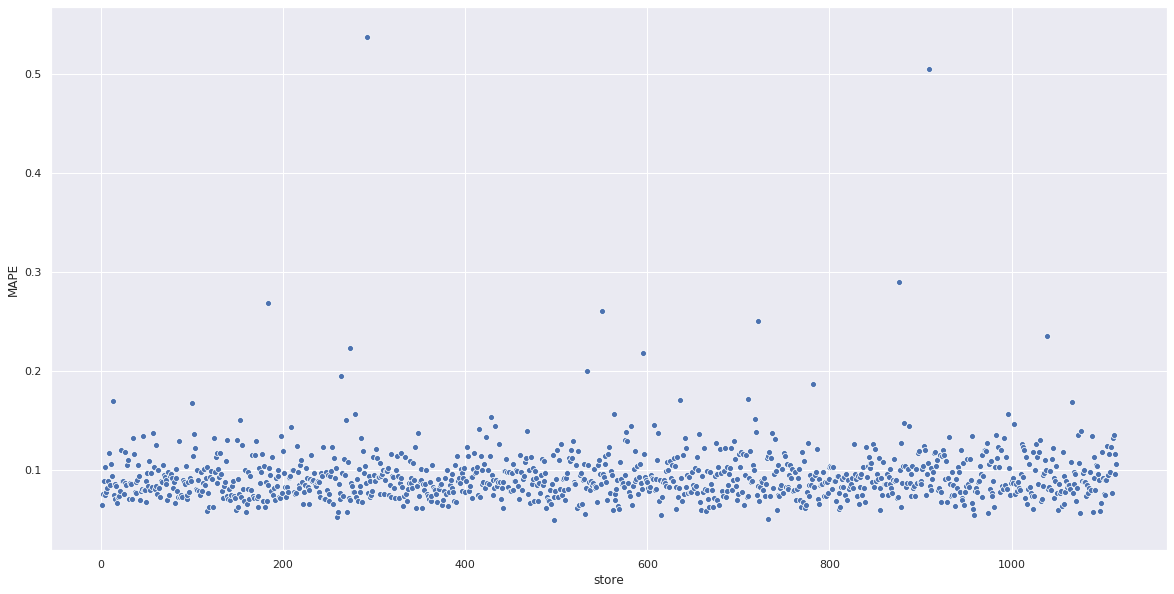

In [110]:
sns.scatterplot(x= 'store', y= 'MAPE', data= dataframe_business_performance);

## Total Performance

In [111]:
dataframe_total_performance = dataframe_business_performance[['predictions', 'worst_scenarios', 'best_scenarios']].apply(lambda x: np.sum(x), axis= 0).reset_index().rename(columns= {'index': 'scenarios', 0: 'values'})
dataframe_total_performance['values'] = dataframe_total_performance['values'].map('R${:,.2f}'.format)
dataframe_total_performance

,scenarios,values
0,predictions,"R$283,636,608.00"
1,worst_scenarios,"R$257,525,527.23"
2,best_scenarios,"R$309,747,687.27"


## Machine Learning Performance

In [112]:
dataframe_9['error'] = dataframe_9['sales'] - dataframe_9['predictions']
dataframe_9['error_rate'] = dataframe_9['predictions'] / dataframe_9['sales']

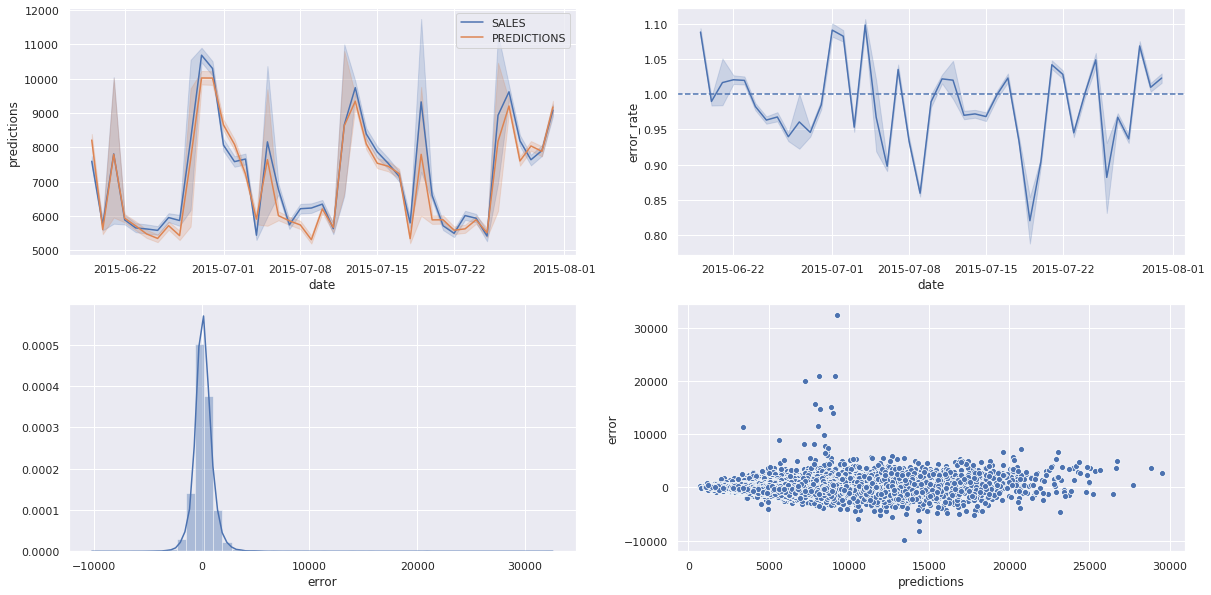

In [113]:
plt.subplot(2, 2, 1)
sns.lineplot(x= 'date', y= 'sales', data= dataframe_9, label= 'SALES');
sns.lineplot(x= 'date', y= 'predictions', data= dataframe_9, label= 'PREDICTIONS');

plt.subplot(2, 2, 2)
sns.lineplot(x= 'date', y= 'error_rate', data= dataframe_9);
plt.axhline(1, linestyle= '--')

plt.subplot(2, 2, 3)
sns.distplot(dataframe_9['error']);

plt.subplot(2, 2, 4)
sns.scatterplot(dataframe_9['predictions'], dataframe_9['error']);

# Deploy Model to Production

## Rossmann Class

In [114]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path= '/home/pietro/Documents/MyJourneyDS/ComunidadeDS/DSemProducao/my-codes/parameters'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'competition_distance_scaler', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'competition_time_month_scaler', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'promo_time_week_scaler', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'year_scaler', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'story_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, dataframe):

        ## Rename Columns
        old_columns = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        new_columns = list(map(snakecase, old_columns))

        dataframe.columns = new_columns

        
        ## Data Types
        dataframe['date'] = pd.to_datetime(dataframe['date'])

        
        ## Fillout NAN
        # competition_distance (distância em mêtros até a loja concorrente mais próxima)
        dataframe['competition_distance'] = dataframe['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month (fornece o mês aproximados em que o concorrente mais próximo foi aberto)
        dataframe['competition_open_since_month'] = dataframe.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis= 1)

        # competition_open_since_year (fornece o ano aproximados em que o concorrente mais próximo foi aberto)
        dataframe['competition_open_since_year'] = dataframe.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis= 1)

        # promo2_since_week (descreve a semana em que a loja começou a participar da Promo2)
        dataframe['promo2_since_week'] = dataframe.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis= 1)

        # promo2_since_year (descreve o ano em que a loja começou a participar da Promo2)      
        dataframe['promo2_since_year'] = dataframe.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis= 1)

        #promo_interval (descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é reiniciada. )
        month_map = {1: 'Jan', 2: 'Fev',3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        dataframe['promo_interval'].fillna(0, inplace= True)

        dataframe['month_map'] = dataframe['date'].dt.month.map(month_map)

        dataframe['is_promo'] = dataframe[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis= 1)

        
        ## Change Data Types
        #competition
        dataframe['competition_open_since_month'] = dataframe['competition_open_since_month'].astype(int)
        dataframe['competition_open_since_year'] = dataframe['competition_open_since_year'].astype(int)

        #promo2
        dataframe['promo2_since_week'] = dataframe['promo2_since_week'].astype(int)
        dataframe['promo2_since_year'] = dataframe['promo2_since_year'].astype(int)
        
        
        return dataframe
        
    def feature_engineering(self, dataframe_2):
        
        ## Feature Engineering
        #year
        dataframe_2['year'] = dataframe_2['date'].dt.year

        #month
        dataframe_2['month'] = dataframe_2['date'].dt.month

        #day
        dataframe_2['day'] = dataframe_2['date'].dt.day

        #week of year
        dataframe_2['week_of_year'] = dataframe_2['date'].dt.weekofyear

        #year week
        dataframe_2['year_week'] = dataframe_2['date'].dt.strftime('%Y-%W')

        #competition since 
        dataframe_2['competition_since'] = dataframe_2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1), axis= 1)
        dataframe_2['competition_time_month'] = ((dataframe_2['date'] - dataframe_2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        #promo since
        dataframe_2['promo_since'] = dataframe_2['promo2_since_year'].astype(str) + '-' + dataframe_2['promo2_since_week'].astype(str)
        dataframe_2['promo_since'] = dataframe_2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days= 7))
        dataframe_2['promo_time_week'] = ((dataframe_2['date'] - dataframe_2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        # assortment
        dataframe_2['assortment'] = dataframe_2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #state holiday 
        dataframe_2['state_holiday'] = dataframe_2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
    

        ## Filtering Variables
        ### Line Filtering
        dataframe_2 = dataframe_2[dataframe_2['open'] != 0]

        ### Column Selection
        excluded_columns = ['open', 'promo_interval', 'month_map']
        dataframe_2 = dataframe_2.drop(excluded_columns, axis= 1)
        
        
        return dataframe_2
    
    def data_preparation(self, dataframe_3):
        
        ## Rescaling
        # competition distance
        dataframe_3['competition_distance'] = self.competition_distance_scaler.transform(dataframe_3[['competition_distance']].values)

        # competition time month
        dataframe_3['competition_time_month'] = self.competition_time_month_scaler.transform(dataframe_3[['competition_time_month']].values)

        # promo time week
        dataframe_3['promo_time_week'] = self.promo_time_week_scaler.transform(dataframe_3[['promo_time_week']].values)

        #year
        dataframe_3['year'] = self.year_scaler.transform(dataframe_3[['year']].values)

        
        ## Transformation
        ### Encoding
        # state holiday >>> one hot encoding
        dataframe_3 = pd.get_dummies(dataframe_3, prefix= ['state_holiday'], columns= ['state_holiday'])

        # store type >>> label encoding
        dataframe_3['store_type'] = self.store_type_scaler.transform(dataframe_3['store_type'])

        # assortment >>> ordinal encoding
        assortment_dictionary = {'basic': 1, 'extra': 2, 'extended': 3}
        dataframe_3['assortment'] = dataframe_3['assortment'].map(assortment_dictionary)

        ### Nature Transformation
        # day of week
        dataframe_3['day_of_week_sin'] = dataframe_3['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/7)))
        dataframe_3['day_of_week_cos'] = dataframe_3['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/7)))

        # month
        dataframe_3['month_sin'] = dataframe_3['month'].apply(lambda x: np.sin( x * (2 * np.pi/12)))
        dataframe_3['month_cos'] = dataframe_3['month'].apply(lambda x: np.cos( x * (2 * np.pi/12)))

        # day
        dataframe_3['day_sin'] = dataframe_3['day'].apply(lambda x: np.sin( x * (2 * np.pi/30)))
        dataframe_3['day_cos'] = dataframe_3['day'].apply(lambda x: np.cos( x * (2 * np.pi/30)))

        # week of year
        dataframe_3['week_of_year_sin'] = dataframe_3['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/52)))
        dataframe_3['week_of_year_cos'] = dataframe_3['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/52)))
        
        columns_selected = ['store', 'promo', 'store_type', 'assortment',
                            'competition_distance', 'competition_open_since_month',
                            'competition_open_since_year', 'promo2', 'promo2_since_week',
                            'promo2_since_year', 'competition_time_month', 'promo_time_week',
                            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
                            'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        
        return dataframe_3[columns_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient= 'records', date_format= 'iso')

## API Handler

In [115]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
infile = open('/home/pietro/Documents/MyJourneyDS/ComunidadeDS/DSemProducao/my-codes/model/model_rossmann.pkl', 'rb')
model = pickle.load(infile)
infile.close()

#inicialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance(test_json, dict): #Unique example
            test_raw = pd.DataFrame(test_json, index= [0])
        
        else: #Multiple example
            test_raw = pd.DataFrame(test_json, columns= test_json[0].keys())
            
        #Instantiate Rossmann Class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = feature_engineering(df1)
        
        #data_preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status= 200, mimetype= 'application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## API Tester

In [5]:
test_dataframe = pd.read_csv('/home/pietro/Documents/MyJourneyDS/ComunidadeDS/DSemProducao/my-codes/data/test.csv')

In [8]:
#merge test dataset + store dataset
dataframe_10 = pd.merge(test_dataframe, store_dataframe, how= 'left', on= 'Store')

#choose store for prediction
dataframe_10 = dataframe_10[dataframe_10['Store'] == 22]

#remove closed days 
dataframe_10 = dataframe_10[dataframe_10['Open'] != 0]
dataframe_10 = dataframe_10[~dataframe_10['Open'].isnull()]
dataframe_10 = dataframe_10.drop('Id', axis= 1)

In [10]:
#convert Dataframe to Json
data = json.dumps(dataframe_10.to_dict(orient= 'records'))

In [32]:
#API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url= 'https://rossmann-rodrigorngl.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers= header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [28]:
d1 = pd.DataFrame(r.json(), columns= r.json()[0].keys())

In [30]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell ${:,.2f} in the next 6 week'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store Number 22 will sell $211,194.11 in the next 6 week
